# Gerekli kütüphaneler

In [2]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Veriseti yüklemesi

In [3]:
df = pd.read_csv('data_banknote_authentication.csv', sep=';')

# Veriye ilk bakış

In [4]:
print(df.head())

  variance skewness curtosis   entropy  class
0   36.216   86.661  -28.073  -0.44699      0
1   45.459   81.674  -24.586 -14.62100      0
2    3.866  -26.383   19.242   0.10645      0
3   34.566   95.228  -40.112 -35.94400      0
4  0.32924  -44.552   45.718  -0.98880      0


In [5]:
print(df.tail())

     variance  skewness curtosis   entropy  class
1367  0.40614    13.492  -14.501  -0.55949      1
1368  -13.887   -48.773   64.774   0.34179      1
1369  -37.503  -134.586  175.932 -27.77100      1
1370  -35.637   -83.827   12.393 -12.82300      1
1371  -25.419  -0.65804   26.842  11.95200      1


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   object 
 1   skewness  1372 non-null   object 
 2   curtosis  1372 non-null   object 
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 53.7+ KB
None


In [7]:
# object olarak gözüken değişkenlerin kategorik değişkene çevrilmesi

df.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'y']

df.variance = pd.Categorical(df.variance)
df.skewness = pd.Categorical(df.skewness) 
df.curtosis = pd.Categorical(df.curtosis)


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   variance  1372 non-null   category
 1   skewness  1372 non-null   category
 2   curtosis  1372 non-null   category
 3   entropy   1372 non-null   float64 
 4   y         1372 non-null   int64   
dtypes: category(3), float64(1), int64(1)
memory usage: 156.7 KB
None


# 2. Veri Setinin Betimlenmesi

In [9]:
df.describe().T # eksik gözlemleri göz ardı eder ve kategorik değişkenleri görmezden gelir

,count,mean,std,min,25%,50%,75%,max
entropy,1372.0,-11.475199,20.218128,-85.482,-21.978,-0.58665,0.39481,24.495
y,1372.0,0.444606,0.497103,0.000,0.000,0.00000,1.00000,1.000


# 3. Eksik Değerlerin İncelenmesi

In [10]:
df.isnull().values.any()

np.False_

In [11]:
df.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
y           0
dtype: int64

eksik veri incelenmsi --> null değerlerin 0 ile değiştirmek gibi
bu veriseti için en uygun yöntemi araştır !!!

# 4. Kategorik Değişken Özeti

In [12]:
print(df.head())


  variance skewness curtosis   entropy  y
0   36.216   86.661  -28.073  -0.44699  0
1   45.459   81.674  -24.586 -14.62100  0
2    3.866  -26.383   19.242   0.10645  0
3   34.566   95.228  -40.112 -35.94400  0
4  0.32924  -44.552   45.718  -0.98880  0


In [13]:
katDf = df.select_dtypes(include=['category'])

In [14]:
print(katDf.head())

  variance skewness curtosis
0   36.216   86.661  -28.073
1   45.459   81.674  -24.586
2    3.866  -26.383   19.242
3   34.566   95.228  -40.112
4  0.32924  -44.552   45.718


In [16]:
# kategoriler neler 
katDf.variance.unique()

['36.216', '45.459', '3.866', '34.566', '0.32924', ..., '0.40614', '-13.887', '-37.503', '-35.637', '-25.419']
Length: 1338
Categories (1338, object): ['-0.0012852', '-0.0068919', '-0.014902', '-0.016103', ..., '65.633', '68.248', 'Mar.82', 'Nis.65']

In [ ]:
# kaç kategori var
katDf["variance"].value_counts().count()

np.int64(1338)

In [18]:
#kategorilerin frekansları
katDf["variance"].value_counts()

variance
0.5706      5
0.3798      4
0.3292      4
0.5195      4
-0.2062     3
           ..
50.617      1
50.691      1
51.129      1
51.213      1
-0.10234    1
Name: count, Length: 1338, dtype: int64

<Axes: ylabel='y'>

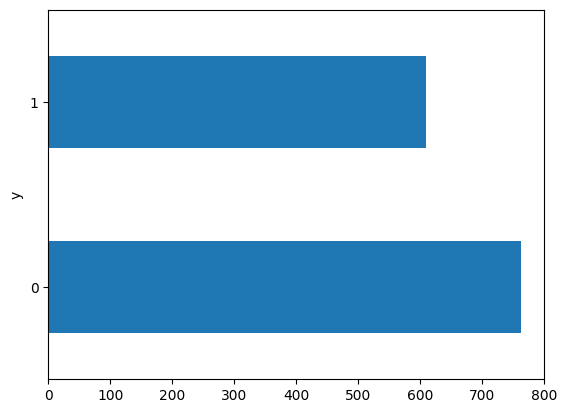

In [28]:
df["y"].value_counts().plot.barh() # diğer grafikler çok karışık

# 5. Sürekli Değişken Özetleri

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   variance  1372 non-null   category
 1   skewness  1372 non-null   category
 2   curtosis  1372 non-null   category
 3   entropy   1372 non-null   float64 
 4   y         1372 non-null   int64   
dtypes: category(3), float64(1), int64(1)
memory usage: 156.7 KB


In [30]:
numDf = df.select_dtypes(include=['float64', 'int64'])
print(numDf.head())

    entropy  y
0  -0.44699  0
1 -14.62100  0
2   0.10645  0
3 -35.94400  0
4  -0.98880  0


In [31]:
numDf.describe().T

,count,mean,std,min,25%,50%,75%,max
entropy,1372.0,-11.475199,20.218128,-85.482,-21.978,-0.58665,0.39481,24.495
y,1372.0,0.444606,0.497103,0.000,0.000,0.00000,1.00000,1.000


In [33]:
print("Ortalama: " + str(numDf["entropy"].mean()))
print("Dolu Gözlem Sayısı: " + str(numDf["entropy"].count())) 
print("Maksimum Değer: " + str(numDf["entropy"].max()))
print("Minimum Değer: " + str(numDf["entropy"].min()))
print("Medyan: " + str(numDf["entropy"].median()))
print("Standart Sapma: " + str(numDf["entropy"].std()))

Ortalama: -11.475198866982508
Dolu Gözlem Sayısı: 1372
Maksimum Değer: 24.495
Minimum Değer: -85.482
Medyan: -0.58665
Standart Sapma: 20.218127522785945


# 6. Dağılım Grafikleri

In [37]:
# ordinal tanımlama
from pandas.api.types import CategoricalDtype

In [36]:
df.variance.head()

0     36.216
1     45.459
2      3.866
3     34.566
4    0.32924
Name: variance, dtype: category
Categories (1338, object): ['-0.0012852', '-0.0068919', '-0.014902', '-0.016103', ..., '65.633', '68.248', 'Mar.82', 'Nis.65']

In [ ]:
# variance isimli değişkeni ordinal olarak tanımlama
df.variance = df.variance.astype(CategoricalDtype (ordered=True))

In [40]:
df.dtypes   

variance    category
skewness    category
curtosis    category
entropy      float64
y              int64
dtype: object

In [42]:
df.variance.head()

0     36.216
1     45.459
2      3.866
3     34.566
4    0.32924
Name: variance, dtype: category
Categories (1338, object): ['-0.0012852' < '-0.0068919' < '-0.014902' < '-0.016103' ... '65.633' < '68.248' < 'Mar.82' < 'Nis.65']

# 6. Barplot (sütun grafik)

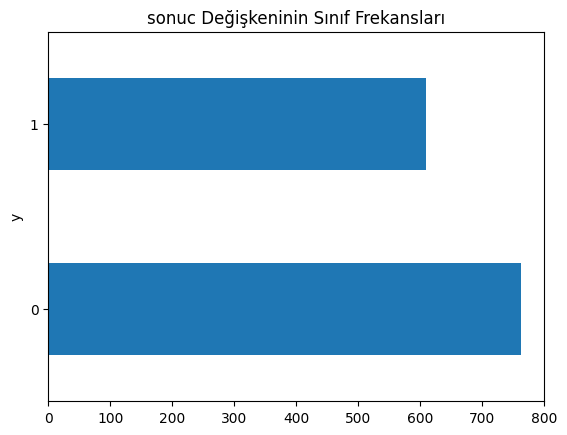

In [45]:
df["y"].value_counts().plot.barh().set_title("sonuc Değişkeninin Sınıf Frekansları");

# 6.1.1